In [1]:
# import necessary packages
import os
import pandas
import numpy
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path
# import function for querying DOE dataframes
from monte_carlo_utils import get_DOE_atb, get_DOE_barges

# set file location and name
atb_shp_path = Path('/data/MIDOSS/shapefiles/atb_2018_01.shp')
barge_shp_path = Path('/data/MIDOSS/shapefiles/barge_2018_01.shp')
doe_xls_path = Path('/data/MIDOSS/spreadsheets/MuellerTrans4-30-20.xlsx')
fac_xls_path = Path(
    '/home/rmueller/Projects/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx'
)

# import facility locations
facWA = pandas.read_excel(
    fac_xls_path,
    sheet_name = 'Washington',
    usecols="B,D,J,K"
)

# import shapefile using geopandas
allTracks = {} 
allTracks['atb']= gpd.read_file(atb_shp_path)
allTracks['barge'] = gpd.read_file(barge_shp_path)

# view  the top 6 lines of attribute table of data
allTracks['atb'].head(1)

,MMSI_NUM,ST_DATE,EN_DATE,LENGTH,TO,FROM_,geometry
0,316001223.0,2018-01-01 00:03:48,2018-01-01 00:05:58,41,US,US,"LINESTRING (-122.77574 48.33663, -122.77796 48..."


In [2]:
def concat_shp(ship_type):
    """
      INPUT: 
          - ship_type ["tanker", "barge", "atb", etc]: MIDOSS-name for ship type (see oil_attribution.yaml for list)
      OUTPUT: 
          - dataframe of all 2018 ship tracks for given ship_type
      requirements: 
          This script requires being run on Salish.eoas.ubc.ca, with path to shapefiles being /data/MIDOSS/shapefiles/
    """
    for months in range(1,13):
        # set file location and name
        shp_path = Path(f'/data/MIDOSS/shapefiles/{ship_type}_2018_{months:02d}.shp')
        # import shapefile using geopandas
        monthly_shp = gpd.read_file(shp_path)
        if months == 1:
            print(f'creating {ship_type} shapefile for 2018, starting with January data')
            allTracks = monthly_shp
        else:
            print(f'Concatenating {ship_type} data from month {months}')
            allTracks = gpd.GeoDataFrame(
                pandas.concat([allTracks, monthly_shp])
            )
    return allTracks

# Concatenate all monthly ship track data to get values for entire year

### ATBs

In [3]:
%%time
allTracks = {} 
allTracks["atb"] = concat_shp("atb")

creating atb shapefile for 2018, starting with January data
Concatenating atb data from month 2
Concatenating atb data from month 3
Concatenating atb data from month 4
Concatenating atb data from month 5
Concatenating atb data from month 6
Concatenating atb data from month 7
Concatenating atb data from month 8
Concatenating atb data from month 9
Concatenating atb data from month 10
Concatenating atb data from month 11
Concatenating atb data from month 12
CPU times: user 40.4 s, sys: 819 ms, total: 41.2 s
Wall time: 42.5 s


In [46]:
# play around with parallelizing for efficiency
from dask import delayed
test = delayed(concat_shp("atb"))
test.compute()

ModuleNotFoundError: No module named 'dask'

### Barges

In [4]:
%%time
allTracks["barge"] = concat_shp("barge")

creating barge shapefile for 2018, starting with January data
Concatenating barge data from month 2
Concatenating barge data from month 3
Concatenating barge data from month 4
Concatenating barge data from month 5
Concatenating barge data from month 6
Concatenating barge data from month 7
Concatenating barge data from month 8
Concatenating barge data from month 9
Concatenating barge data from month 10
Concatenating barge data from month 11
Concatenating barge data from month 12
CPU times: user 15min 39s, sys: 36.7 s, total: 16min 16s
Wall time: 16min 18s


### Tankers

In [5]:
%%time
ship_type = "tanker"
allTracks["tanker"] = concat_shp("tanker")

creating tanker shapefile for 2018, starting with January data
Concatenating tanker data from month 2
Concatenating tanker data from month 3
Concatenating tanker data from month 4
Concatenating tanker data from month 5
Concatenating tanker data from month 6
Concatenating tanker data from month 7
Concatenating tanker data from month 8
Concatenating tanker data from month 9
Concatenating tanker data from month 10
Concatenating tanker data from month 11
Concatenating tanker data from month 12
CPU times: user 1min 20s, sys: 2.21 s, total: 1min 22s
Wall time: 1min 23s


## Check barge ship track count used in ping-to-transfer ratio estimate
- values recorded in `Origin_Destination_Analysis_updated.xlsx`

In [47]:
print(f'{allTracks["atb"].shape[0]} ATB ship tracks')
print(f'cf. 588,136 ATB ship tracks used in ping-to-transfer estimate')
print(f'{allTracks["barge"].shape[0]} barge ship tracks')

588136 ATB ship tracks
cf. 588,136 ATB ship tracks used in ping-to-transfer estimate
13902896 barge ship tracks


## Find all ATB and barge tracks with generic attribution as both origin and destination

In [6]:
attribution = ['US','Canada','Pacific']
noNone = {}
allNone = {}
generic = {}

for vessel_type in ["atb",'barge']:
    generic[vessel_type] = allTracks[vessel_type].loc[
        (allTracks[vessel_type].TO.isin(attribution)) & 
        (allTracks[vessel_type].FROM_.isin(attribution))
    ]

In [7]:
generic["barge"].shape

(5865057, 7)

### Find all ship tracks with origin or destination as marine terminal
- compare this value to frac[vessel_type]["marine_terminal"] to quantify how many ship tracks have mixed origin/destation as marine_terminal/generic (I don't think mixed with None is possible). 

In [56]:
allfac = {}
toWA = {}
fromWA = {}
bothWA = {}
for vessel_type in ["atb",'barge']:
    allfac[vessel_type] = allTracks[vessel_type].loc[
        ((allTracks[vessel_type].TO.isin(facWA.FacilityName)) |
         (allTracks[vessel_type].FROM_.isin(facWA.FacilityName)))
    ]
    toWA[vessel_type] = allTracks[vessel_type].loc[
        (allTracks[vessel_type].TO.isin(facWA.FacilityName))
    ] 
    fromWA[vessel_type] = allTracks[vessel_type].loc[
         (allTracks[vessel_type].FROM_.isin(facWA.FacilityName))
    ] 
    bothWA[vessel_type] = allTracks[vessel_type].loc[
        ((allTracks[vessel_type].TO.isin(facWA.FacilityName)) &
         (allTracks[vessel_type].FROM_.isin(facWA.FacilityName)))
    ] 

In [59]:
print(f'To OR From: {allfac["atb"].shape[0]}')  
print(f'To AND From: {bothWA["atb"].shape[0]}')  
print(f'To: {toWA["atb"].shape[0]}')
print(f'From: {fromWA["atb"].shape[0]}')
print(f'To + From: {toWA["atb"].shape[0] + fromWA["atb"].shape[0]}')
print(f'To + From - "To AND from": {toWA["atb"].shape[0] + fromWA["atb"].shape[0] - bothWA["atb"].shape[0]}')

To OR From: 129165
To AND From: 13238
To: 58520
From: 83883
To + From: 142403
To + From - "To AND from": 129165


##### TAKE-AWAY: 
- 129165 ship tracks are to or from WA marine terminals with 
- 13238 of these having WA marine terminal as both to and from
- The remainder are mixed with origin or destination as WA marine terminal and the other end-member being US, Pacific, Canada or CAD marine terminal (None values shouldn't be includeded here) 

##### TEST: 
- All tracks = Generic + allFac + None

In [61]:
print(f'All tracks = Generic + allFac + allNone')
print(f'{allTracks["atb"].shape[0]} = {generic["atb"].shape[0] + allfac["atb"].shape[0] + allNone["atb"].shape[0]}')

All tracks = Generic + allFac + allNone
588136 = 476681


In [63]:
# the difference in the above is either CAD terminals <-> WA terminals or None <-> WA terminals
# See if there are NONE values in allfac
# keep rows with None attribution 
vessel_type = "atb"
shp_tmp = allfac[vessel_type].isnull()
row_has_None = shp_tmp.any(axis=1)
test = allfac[vessel_type][row_has_None]
test.shape[0]

0

In [65]:
# Good!  So 588136 - 476681  = 111455 => CAD traffic.  Test...

In [58]:
# compare ATB tracks
vessel_type = "atb"
print(f'Attributed (no None in to or from): {noNone[vessel_type].shape[0]}')
print(f'Generic (to AND from): {generic[vessel_type].shape[0]}')
print(f'Attributed - Generic = {noNone[vessel_type].shape[0] - generic[vessel_type].shape[0]}')
print(f'Marine terminal (to or from): {allfac[vessel_type].shape[0]}')

Attributed (no None in to or from): 359943
Generic (to AND from): 119323
Attributed - Generic = 240620
Marine terminal (to or from): 129165


## Find all ship tracks with None as origin and destination

In [8]:
for vessel_type in ["atb",'barge']:
    # keep rows with None attribution 
    shp_tmp = allTracks[vessel_type].isnull()
    row_has_None = shp_tmp.any(axis=1)
    allNone[vessel_type] = allTracks[vessel_type][row_has_None]

## Find all ship tracks with no None designations in either origin or destination

In [9]:
for vessel_type in ["atb",'barge']:
    # drop rows with None attribution
    noNone[vessel_type] = allTracks[vessel_type].dropna().reset_index(drop=True)

In [10]:
# create a dictionary of ratios between subsampled data and all ship tracks
frac = {}
frac['atb'] = {}
frac['barge'] = {}
for vessel_type in ["atb","barge"]:
    frac[vessel_type]["unattributed"] = allNone[vessel_type].shape[0]/allTracks[vessel_type].shape[0]
    frac[vessel_type]["attributed"] = noNone[vessel_type].shape[0]/allTracks[vessel_type].shape[0]
    frac[vessel_type]["generic"] = generic[vessel_type].shape[0]/allTracks[vessel_type].shape[0]
    frac[vessel_type]["marine_terminal"] = frac[vessel_type]["attributed"] - frac[vessel_type]["generic"]
    print(f'~~~  {vessel_type} ~~~')
    print(f'Fraction of {vessel_type} tracks that are unattributed: {frac[vessel_type]["unattributed"]}')
    print(f'Fraction of {vessel_type} tracks that are attributed: {frac[vessel_type]["attributed"]}')
    print(f'Fraction of attributed {vessel_type} tracks that are generic : {frac[vessel_type]["generic"]}')
    print(f'Fraction of attributed {vessel_type} tracks that are linked to marine terminal: {frac[vessel_type]["marine_terminal"]}')

~~~  atb ~~~
Fraction of atb tracks that are unattributed: 0.38799359331855215
Fraction of atb tracks that are attributed: 0.6120064066814478
Fraction of attributed atb tracks that are generic : 0.20288334670892447
Fraction of attributed atb tracks that are linked to marine terminal: 0.4091230599725233
~~~  barge ~~~
Fraction of barge tracks that are unattributed: 0.4340840929832173
Fraction of barge tracks that are attributed: 0.5659159070167827
Fraction of attributed barge tracks that are generic : 0.4218586544846484
Fraction of attributed barge tracks that are linked to marine terminal: 0.14405725253213436


In [11]:
for vessel_type in ["atb","barge"]:
    print(f'Total number of tracks for {vessel_type}: {allTracks[vessel_type].shape[0]:1.2e}')

Total number of tracks for atb: 5.88e+05
Total number of tracks for barge: 1.39e+07


In [12]:
print(f'Total number of unattributed barge tracks: {allTracks[vessel_type].shape[0]*frac[vessel_type]["unattributed"]:10.2f}')
print(f'Total number of generically-attributed barge tracks: {allTracks[vessel_type].shape[0]*frac[vessel_type]["generic"]:10.2f}')
print(f'Total number of marine-terminal-attributed barge tracks: {allTracks[vessel_type].shape[0]*frac[vessel_type]["marine_terminal"]:10.2f}')

Total number of unattributed barge tracks: 6035026.00
Total number of generically-attributed barge tracks: 5865057.00
Total number of marine-terminal-attributed barge tracks: 2002813.00


## Quantify barge and ATB cargo transfers in 2018 DOE database

In [13]:
[atb_in, atb_out]=get_DOE_atb(
    doe_xls_path, 
    fac_xls_path, 
    transfer_type = 'cargo', 
    facilities='selected'
)

barge_inout=get_DOE_barges(
    doe_xls_path,
    fac_xls_path, 
    direction='combined',
    facilities='selected',
    transfer_type = 'cargo')

get_DOE_barges: not yet tested with fac_xls as input
combined
cargo
cargo


In [14]:
transfers = {}
transfers["barge"] = barge_inout.shape[0]
transfers["atb"] = atb_in.shape[0] + atb_out.shape[0]
print(f'{transfers["atb"]} cargo transfers for atbs')
print(f'{transfers["barge"]} cargo transfers for barges')

677 cargo transfers for atbs
2773 cargo transfers for barges


### Calculate the number of Attributed tracks we get for ATBs and estimate the equivalent value for barges

In [15]:
# estimate the ratio of attributed ATB tracks to ATB cargo transfers
noNone_ratio = noNone["atb"].shape[0]/transfers["atb"]
print(f'We get {noNone_ratio:.2f} attributed ATB tracks per ATB cargo transfer')
# estimate the amount of attributed tracks we'd expect to see for tank barges based on tank barge transfers
print(f'We expect {noNone_ratio*transfers["barge"]:.2f} attributed barge tracks, but we get {noNone["barge"].shape[0]}')
# estimate spurious barge voyages by removing estimated oil carge barge from total
fraction_nonoilbarge = (noNone["barge"].shape[0]-noNone_ratio*transfers["barge"])/noNone["barge"].shape[0]
print(f'We estimate that non-oil tank barge voyages account for {100*fraction_nonoilbarge:.2f}% of barge voyages')

We get 531.67 attributed ATB tracks per ATB cargo transfer
We expect 1474330.78 attributed barge tracks, but we get 7867870
We estimate that non-oil tank barge voyages account for 81.26% of barge voyages


## Now look more carefully at marine terminal attributions to get a sense of how much oil cargo tug traffic "moonlights" with other non-oil gigs.  

In [16]:
facWA.head()

,FacilityName,FacilityDOEName,DockLatNumber,DockLongNumber
0,BP Cherry Point Refinery,BP Cherry Point Refinery,48.86111,-122.758
1,Shell Puget Sound Refinery,Shell Puget Sound Refinery,48.50945,-122.577
2,Shell Oil LP Seattle Distribution Terminal,Shell Oil LP Seattle Distribution Terminal,47.58870,-122.353
3,Maxum Petroleum - Harbor Island Terminal,Maxum (Rainer Petroleum),47.58753,-122.353
4,Tidewater Snake River Terminal,Tidewater Snake River Terminal,46.22312,-119.014


In [17]:
allfac = {}
for vessel_type in ["atb",'barge']:
    allfac[vessel_type] = allTracks[vessel_type].loc[
        ((allTracks[vessel_type].TO.isin(facWA.FacilityName)) |
         (allTracks[vessel_type].FROM_.isin(facWA.FacilityName)))
    ] 

In [18]:
allfac["barge"].shape

(1666271, 7)

In [19]:
print(f'{allfac["atb"].shape[0]} ATB tracks have a WA oil facility as origin or destination')
print(f'{allfac["barge"].shape[0]} barge tracks have a WA oil facility as origin or destination')
fac_att_ratio = allfac["atb"].shape[0]/transfers["atb"]
print(f'We get {fac_att_ratio:.2f} WA oil marine terminal attributed ATB tracks per ATB cargo transfer')
# estimate the amount of oil cargo facility tracks we'd expect to see for tank barges based on tank barge transfers
print(f'We expect {fac_att_ratio*transfers["barge"]:.2f} WA oil marine terminal attributed barge tracks, but we get {allfac["barge"].shape[0]}')
fraction_nonoilbarge = (allfac["barge"].shape[0]-fac_att_ratio*transfers["barge"])/allfac["barge"].shape[0]
print(f'We estimate that non-oil tank barge voyages to/from marine terminals account for {100*fraction_nonoilbarge:.2f}% of barge voyages attributed to WA marine terminals')


129165 ATB tracks have a WA oil facility as origin or destination
1666271 barge tracks have a WA oil facility as origin or destination
We get 190.79 WA oil marine terminal attributed ATB tracks per ATB cargo transfer
We expect 529061.37 WA oil marine terminal attributed barge tracks, but we get 1666271
We estimate that non-oil tank barge voyages to/from marine terminals account for 68.25% of barge voyages attributed to WA marine terminals


In [20]:
100 - 68.25

31.75

## Repeat for Generic attibution only

In [21]:
print(f'{generic["atb"].shape[0]} ATB tracks have Pacific, US or Canada as origin or destination')
print(f'{generic["barge"].shape[0]} barge tracks have Pacific, US or Canada as origin or destination')
generic_ratio = generic["atb"].shape[0]/transfers["atb"]
print(f'We get {generic_ratio:.2f} Generically attributed ATB tracks per ATB cargo transfer')
# estimate the amount of oil cargo facility tracks we'd expect to see for tank barges based on tank barge transfers
print(f'We expect {generic_ratio*transfers["barge"]:.2f} Generically attributed barge tracks, but we get {generic["barge"].shape[0]}')
fraction_nonoilbarge = (generic["barge"].shape[0]-generic_ratio*transfers["barge"])/generic["barge"].shape[0]
print(f'We estimate that non-oil tank barge voyages account for {100*fraction_nonoilbarge:.2f}% of barge voyages with both to/from as generic attributions ')



119323 ATB tracks have Pacific, US or Canada as origin or destination
5865057 barge tracks have Pacific, US or Canada as origin or destination
We get 176.25 Generically attributed ATB tracks per ATB cargo transfer
We expect 488748.42 Generically attributed barge tracks, but we get 5865057
We estimate that non-oil tank barge voyages account for 91.67% of barge voyages with both to/from as generic attributions 


In [22]:
## Repeat for No attribution

In [23]:
print(f'{allNone["atb"].shape[0]} ATB tracks have None as origin or destination')
print(f'{allNone["barge"].shape[0]} barge tracks have None as  as origin or destination')
allNone_ratio = allNone["atb"].shape[0]/transfers["atb"]
print(f'We get {allNone_ratio:.2f} None attributed ATB tracks per ATB cargo transfer')
# estimate the amount of oil cargo facility tracks we'd expect to see for tank barges based on tank barge transfers
print(f'We expect {allNone_ratio*transfers["barge"]:.2f} None attributed barge tracks, but we get {allNone["barge"].shape[0]}')
fraction_nonoilbarge = (allNone["barge"].shape[0]-allNone_ratio*transfers["barge"])/allNone["barge"].shape[0]
print(f'We estimate that non-oil tank barge voyages account for {100*fraction_nonoilbarge:.2f}% of barge voyages with None attributions ')



228193 ATB tracks have None as origin or destination
6035026 barge tracks have None as  as origin or destination
We get 337.06 None attributed ATB tracks per ATB cargo transfer
We expect 934681.22 None attributed barge tracks, but we get 6035026
We estimate that non-oil tank barge voyages account for 84.51% of barge voyages with None attributions 


In [24]:
100-84.51

15.489999999999995

In [25]:
## confirm min length of tanker for min_fuel threshold

In [26]:
allTracks["tanker"].head()

,MMSI_NUM,ST_DATE,EN_DATE,LENGTH,TO,FROM_,geometry
0,219602000.0,2018-01-15 07:56:24,2018-01-15 07:57:24,182,US,Pacific,"LINESTRING (-128.28361 46.80076, -128.27895 46..."
1,219602000.0,2018-01-15 07:57:24,2018-01-15 07:58:58,182,US,Pacific,"LINESTRING (-128.27895 46.80302, -128.27150 46..."
2,219602000.0,2018-01-15 07:58:58,2018-01-15 07:59:27,182,US,Pacific,"LINESTRING (-128.27150 46.80663, -128.26953 46..."
3,219602000.0,2018-01-15 07:59:27,2018-01-15 07:59:46,182,US,Pacific,"LINESTRING (-128.26953 46.80759, -128.26766 46..."
4,219602000.0,2018-01-15 07:59:46,2018-01-15 08:01:24,182,US,Pacific,"LINESTRING (-128.26766 46.80852, -128.26025 46..."


In [27]:
allTracks["tanker"]["LENGTH"].min()

42

In [28]:
allTracks["tanker"]["LENGTH"].max()

287

In [29]:
allTracks["tanker"].loc[
    allTracks["tanker"]["LENGTH"]==42
]

,MMSI_NUM,ST_DATE,EN_DATE,LENGTH,TO,FROM_,geometry
36833,368009250.0,2018-03-09 17:26:56,2018-03-09 17:28:21,42,None,None,"LINESTRING (-122.36612 47.26532, -122.36500 47..."
36834,368009250.0,2018-03-21 14:15:29,2018-03-21 14:17:05,42,None,None,"LINESTRING (-122.36500 47.26500, -122.36618 47..."
36835,368009250.0,2018-03-21 14:17:53,2018-03-21 14:18:28,42,None,None,"LINESTRING (-122.36618 47.26522, -122.36500 47..."
36836,368009250.0,2018-03-21 14:18:28,2018-03-21 14:20:05,42,None,None,"LINESTRING (-122.36500 47.26500, -122.36618 47..."
36837,368009250.0,2018-03-21 14:20:05,2018-03-21 14:21:29,42,None,None,"LINESTRING (-122.36618 47.26523, -122.36500 47..."
...,...,...,...,...,...,...,...
76024,368009250.0,2018-12-28 23:39:16,2018-12-28 23:39:24,42,Kinder Morgan Liquids Terminal - Harbor Island,Kinder Morgan Liquids Terminal - Harbor Island,"LINESTRING (-122.35268 47.58804, -122.35274 47..."
76025,368009250.0,2018-12-28 23:39:24,2018-12-28 23:40:51,42,Kinder Morgan Liquids Terminal - Harbor Island,Kinder Morgan Liquids Terminal - Harbor Island,"LINESTRING (-122.35274 47.58802, -122.35167 47..."
76026,368009250.0,2018-12-31 16:11:35,2018-12-31 16:16:36,42,None,None,"LINESTRING (-122.35167 47.58667, -122.35238 47..."
76027,368009250.0,2018-12-31 16:16:36,2018-12-31 16:17:35,42,None,None,"LINESTRING (-122.35238 47.58760, -122.35167 47..."


### MMSI 368009250 is for GLOBAL PROVIDER
- Check max fuel transfers to get capacity estimate for this size class (42 feet)

In [30]:
from monte_carlo_utils import get_DOE_df
DOEdf = get_DOE_df(
    doe_xls_path, 
    fac_xls_path,
    group = 'no'
)

In [31]:
DOEdf.head(1)

,AntID,StartDateTime,Deliverer,Receiver,Product,TransferQtyInGallon,TransferType,DelivererTypeDescription,ReceiverTypeDescription,ImportRegion,ExportRegion
0,173454,2018-01-01 06:15:00,Maxum Petroleum - Harbor Island Terminal,VICTORIA CLIPPER IV,DIESEL/MARINE GAS OIL,2500.0,Fueling,Facility,PASSENGER SHIP,not attributed,Puget Sound


In [32]:
GP_df = DOEdf.loc[
    DOEdf.Receiver == 'GLOBAL PROVIDER'
]
GP_df.TransferQtyInGallon.max()

155400.0

### Cargo capacity for Global Provider ~ 155400 Gallons

In [33]:
sm_tankers = allTracks["tanker"].loc[
    allTracks["tanker"]["LENGTH"]<155,
    ['LENGTH','MMSI_NUM']
].groupby('LENGTH').count().sort_values(by='MMSI_NUM',ascending=False).reset_index()
sm_tankers

,LENGTH,MMSI_NUM
0,144,47377
1,153,20356
2,42,19025
3,146,11927
4,152,6652
5,149,6040
6,91,4715
7,145,4299
8,147,2695
9,141,2408


Text(0.5, 0, 'Tanker length (meters)')

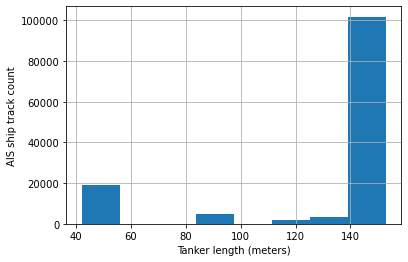

In [34]:
hist=sm_tankers.LENGTH.hist(weights=sm_tankers.MMSI_NUM, bins=8)
hist.set_ylabel('AIS ship track count')
hist.set_xlabel('Tanker length (meters)')

#### create histogram for all tanker lenghts and mmsi

Text(0.5, 0, 'Tanker length (meters)')

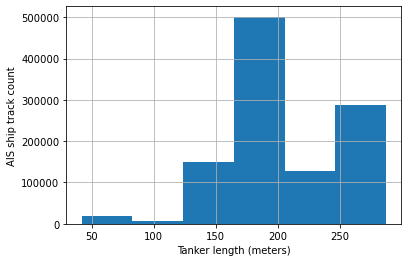

In [35]:
all_tankers = allTracks["tanker"][['LENGTH','MMSI_NUM']].groupby('LENGTH').count().sort_values(by='MMSI_NUM',ascending=False).reset_index()
hist=all_tankers.LENGTH.hist(weights=all_tankers.MMSI_NUM, bins=6)
hist.set_ylabel('AIS ship track count')
hist.set_xlabel('Tanker length (meters)')

In [36]:
all_tankers

,LENGTH,MMSI_NUM
0,183,319343
1,287,78666
2,273,64147
3,182,59741
4,144,47377
...,...,...
59,177,808
60,232,782
61,252,644
62,157,624


In [37]:
allTracks["tanker"][['LENGTH','MMSI_NUM']].groupby('LENGTH').last().sort_values(by='MMSI_NUM',ascending=False).reset_index()

,LENGTH,MMSI_NUM
0,232,636091469.0
1,250,636018579.0
2,183,636018092.0
3,244,636017858.0
4,277,636017061.0
...,...,...
59,275,240546000.0
60,195,238294000.0
61,252,232156000.0
62,176,219124000.0


#### Get representative MMSI for tanker lengths to look up in DOE database

In [38]:
allTracks["tanker"].loc[
    allTracks["tanker"]["LENGTH"]<155,
    ['LENGTH','MMSI_NUM']
].groupby('LENGTH').first()

,MMSI_NUM
LENGTH,
42,368009250.0
89,316041640.0
91,316014610.0
120,212744000.0
127,538006828.0
133,538005277.0
141,371823000.0
144,355320000.0
145,477173600.0


In [39]:
# MMSI 355320000.0 => KIRKEHOLMEN
K_df = DOEdf.loc[
    DOEdf.Receiver == 'KIRKEHOLMEN'
]
K_df.TransferQtyInGallon.max()

3990000.0

### max transfer to Kirkeholmen is 15,103,793.02 liters

In [40]:
sf_df = DOEdf.loc[
    DOEdf.Receiver == 'SEAFRIEND'
]
sf_df.TransferQtyInGallon.max()

nan

In [41]:
allTracks["tanker"].loc[
    allTracks["tanker"].MMSI_NUM == 36713400
]

,MMSI_NUM,ST_DATE,EN_DATE,LENGTH,TO,FROM_,geometry


In [42]:
tanker_list = DOEdf.loc[
    DOEdf.ReceiverTypeDescription == 'TANK SHIP',
    ['Receiver','ReceiverTypeDescription']
].groupby('Receiver').count().sort_values(by='ReceiverTypeDescription', ascending=False).reset_index()

In [43]:
tanker_list

,Receiver,ReceiverTypeDescription
0,KIRKEHOLMEN,91
1,OVERSEAS LOS ANGELES,76
2,PELICAN STATE,73
3,GLOBAL PROVIDER,37
4,AMERICAN FREEDOM,28
...,...,...
118,CHEMBULK WESTPORT,1
119,POMER,1
120,RS AURORA,1
121,BRITISH CHIEF,1


In [44]:
DOEdf.head(1)

,AntID,StartDateTime,Deliverer,Receiver,Product,TransferQtyInGallon,TransferType,DelivererTypeDescription,ReceiverTypeDescription,ImportRegion,ExportRegion
0,173454,2018-01-01 06:15:00,Maxum Petroleum - Harbor Island Terminal,VICTORIA CLIPPER IV,DIESEL/MARINE GAS OIL,2500.0,Fueling,Facility,PASSENGER SHIP,not attributed,Puget Sound


In [45]:
DOEdf.loc[
    DOEdf.Receiver == 'OVERSEAS LOS ANGELES',
    ['TransferQtyInGallon']
].max()

TransferQtyInGallon    11130000.0
dtype: float64